<a href="https://www.kaggle.com/code/mstasyuk/simpsons-classification-resnet18?scriptVersionId=132977914" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Loading Data, Imports

In [1]:
!wget "https://www.dropbox.com/s/2sxx1f5x4f353tq/journey-springfield-augmented.zip?dl=0" -O journey-springfield.zip --quiet
!mkdir data

In [2]:
%%capture
!unzip journey-springfield.zip -d ./data 

In [3]:
%%bash
mv ./data/journey-springfield/testset ./data/test
mv ./data/journey-springfield/train/simpsons_dataset ./data/
rmdir ./data/journey-springfield/train
mv ./data/simpsons_dataset ./data/train
rm -r data/journey-springfield

In [5]:
# My trained model
!wget "https://www.dropbox.com/s/oem33dtm89dx0dh/model.pth?dl=0" -O model.pth --quiet

In [6]:
# Check if data exists
![ -d "./data/train" ] && echo "Directory ./data/train exists."
![ -d "./data/test" ] && echo "Directory ./data/testset exists."

Directory ./data/train exists.
Directory ./data/testset exists.


In [7]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, Subset, DataLoader
from torchvision import transforms, datasets, models

import matplotlib.pyplot as plt

import torch.nn as nn
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
import time
import os
import copy
import pickle

!pip install lion_pytorch --quiet
from lion_pytorch import Lion

from sklearn.model_selection import train_test_split

cudnn.benchmark = True

In [8]:
# Choose processor
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

* I used this article as a backbone
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
* Training data was pre-balanced using method, described by marinalakeeva
https://www.kaggle.com/code/marinalakeeva/data-augmentation

In [9]:
RESCALE_SIZE = 224

# Define simple transforms
augmentations = [
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.5, 1.5)),
    transforms.Resize(35, interpolation=transforms.InterpolationMode.NEAREST_EXACT), 
    transforms.RandomHorizontalFlip(),
]

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomChoice(augmentations),
        transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
        transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
        transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [10]:
data_dir = './data/'

In [11]:
# Create image datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) \
                  for x in ['train', 'test']}

In [12]:
# Split train data to train and val subsets
VAL_SIZE = 0.2
train_idx, validation_idx = train_test_split(np.arange(len(image_datasets['train'])),
                                             test_size=VAL_SIZE,
                                             random_state=1,
                                             shuffle=True,
                                             stratify=image_datasets['train'].targets)

train_set = Subset(image_datasets['train'], train_idx)
val_set = Subset(image_datasets['train'], validation_idx)

print("Train size: {}, validation size: {}".format(len(train_set), len(val_set)))

Train size: 50996, validation size: 12749


In [13]:
VALIDATE = False # Split to train/val if True, otherwise use all training data 

In [14]:
# Create loaders
test_loader = DataLoader(image_datasets['test'], batch_size=64,
                                                 shuffle=False, num_workers=2)

if VALIDATE:
    # Use split data 
    dsets = {'train': train_set, 'val': val_set}
    dataset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
    
    train_loader = DataLoader(dsets['train'], batch_size=32,
                                                 shuffle=True, num_workers=2)
    val_loader = DataLoader(dsets['val'], batch_size=64,
                                                 shuffle=False, num_workers=2)
    
    dataloaders = {'train':train_loader, 'val': val_loader, 'test': test_loader}
    
    
else:
    # Use all training data
    train_set = image_datasets['train']
    train_loader = DataLoader(train_set, batch_size=32,
                                                 shuffle=True, num_workers=2)
    
    dataloaders = {'train':train_loader, 'test': test_loader}
    
    dsets = {'train': train_set}
    dataset_sizes = {'train': len(train_set)}
    
class_names = image_datasets['train'].classes
dataset_sizes

{'train': 63745}

In [15]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    ax.set_title(title)

    return ax

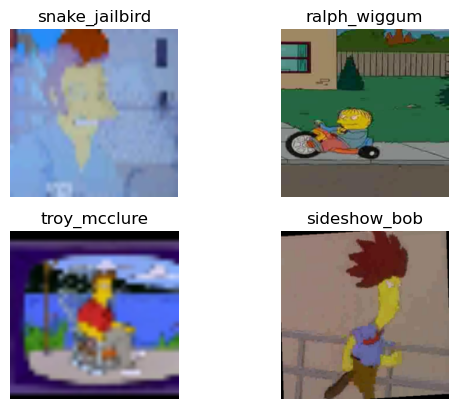

In [16]:
# Visualize training data
images, labels = next(iter(dataloaders['train']))
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2)
imshow(images[0], ax=ax0, normalize=True, title=image_datasets['train'].classes[labels[0]])
imshow(images[1], ax=ax1, normalize=True, title=image_datasets['train'].classes[labels[1]])
imshow(images[2], ax=ax2, normalize=True, title=image_datasets['train'].classes[labels[2]])
imshow(images[3], ax=ax3, normalize=True, title=image_datasets['train'].classes[labels[3]]);

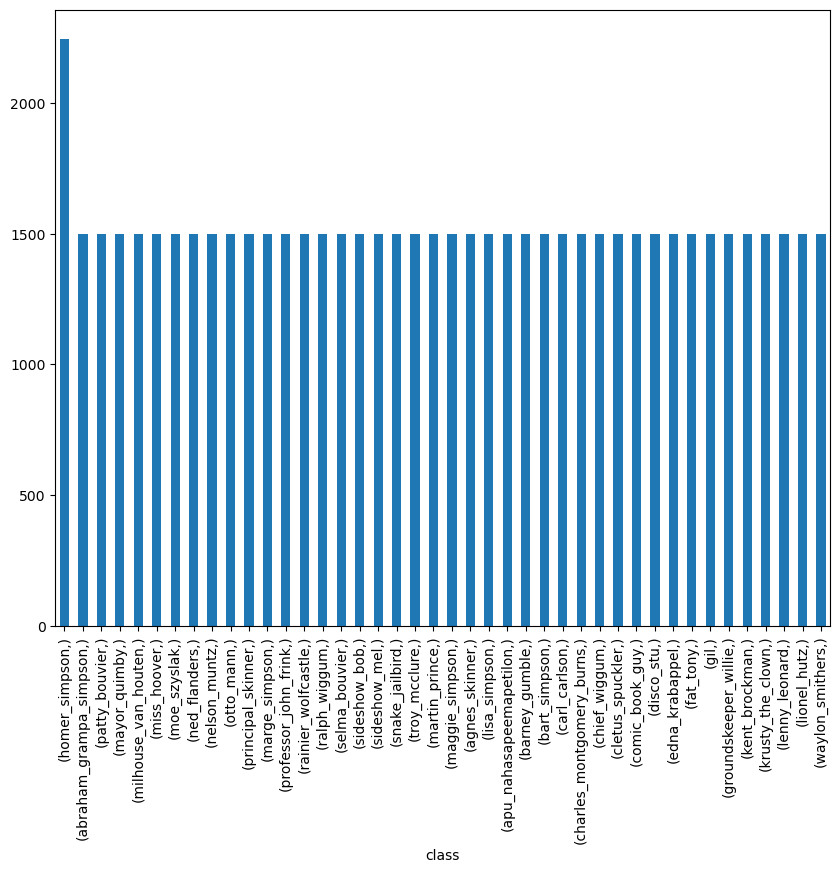

In [17]:
classes = pd.DataFrame(image_datasets['train'].targets, columns=['class']).applymap(lambda x: class_names[x])
plt.figure(figsize=(10,8))
classes.value_counts().plot(kind='bar')

plt.show()

---

### Model

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, validate=True, verbose=True):
    since = time.time()

    phases = ['train', 'val'] if validate else ['train']
    if verbose:
        print('Phases:', phases)
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if validate:
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    if verbose:
                        print(f'Saved best val weights.')
            else:
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    if verbose:
                        print(f'Saved best train weights.')
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [19]:
LR = 1e-4

model_ft = models.resnet18(weights='IMAGENET1K_V1')

# Replace the last layer
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(image_datasets['train'].classes))
model_ft.to(device)

# Define the cost function
criterion = nn.CrossEntropyLoss()

# Define the optimizer. We will use Lion for this task
optimizer_ft = Lion(model_ft.parameters(), lr=LR, weight_decay=1e-2)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 96.4MB/s]


I achieved a fairly good score after several experiments with train/validation splits. After these initial tests, I trained the model on the full dataset.

Due to time constraints, I trained the model incrementally over 25 epochs, split into three sessions: two sets of 10 epochs, and a final set of 5 epochs.

This is why logs are only available for the last 5 epochs.

In [87]:
# Train the model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                          num_epochs=5, validate=VALIDATE)

Phases: ['train']
Epoch 0/4
----------
train Loss: 0.0066 Acc: 0.9983
Saved best train weights.
Epoch 1/4
----------
train Loss: 0.0053 Acc: 0.9987
Saved best train weights.
Epoch 2/4
----------
train Loss: 0.0059 Acc: 0.9985
Epoch 3/4
----------
train Loss: 0.0058 Acc: 0.9983
Epoch 4/4
----------
train Loss: 0.0049 Acc: 0.9988
Saved best train weights.
Training complete in 20m 28s
Best val Acc: 0.998776


---

### Prediction

In [21]:
def predict(model, loader):
    with torch.no_grad():
        logits = []
        for inputs in loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [28]:
# Download my trained model
!wget "https://www.dropbox.com/s/oem33dtm89dx0dh/model.pth?dl=0" -O model.pth --quiet

In [25]:
model_path = '/kaggle/working/model.pth'
model_trained = torch.load(model_path, map_location=torch.device('cpu'))

In [26]:
# Create a list of test images
test_imgs = []
for i in range(len(image_datasets['test'])):
    test_imgs.append(image_datasets['test'][i][0].unsqueeze(0))

In [27]:
# Predict probabilities on test data
imgs = [item[0].unsqueeze(0) for item in image_datasets['test']]
probs = predict(model_trained, imgs)

In [33]:
# Convert probabilities to actual class labels
y_pred = np.argmax(probs,-1)

preds_class = pd.Series([image_datasets['train'].classes[i] for i in y_pred], name='Expected')
preds_class.head()

0              nelson_muntz
1              bart_simpson
2              ned_flanders
3              chief_wiggum
4    apu_nahasapeemapetilon
Name: Expected, dtype: object

In [31]:
filenames = pd.Series([item[0].replace('./data/test/testset/', '') for item in image_datasets['test'].samples], name='Id')

submission_df = pd.concat((filenames, preds_class), axis=1).set_index('Id')
submission_df.head(5)

,Expected
Id,
img0.jpg,nelson_muntz
img1.jpg,bart_simpson
img10.jpg,ned_flanders
img100.jpg,chief_wiggum
img101.jpg,apu_nahasapeemapetilon


In [32]:
submission_df.to_csv('submission.csv')

![](https://imgtr.ee/images/2023/06/09/DelQX.png)